In [3]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

   Unnamed: 0   Age  Gender  Stage  GeneticRisk  TreatmentType  \
0           0  65.0       0      2          1.0              0   
1           1  68.0       1      2          0.0              1   
2           2  68.0       1      3          1.0              1   
3           3  81.0       1      4          1.0              1   
4           4  59.0       1      2          1.0              0   

   ComorbidityIndex  TreatmentResponse  SurvivalTime  Censored  
0               0.0                0.0           4.2         0  
1               1.0                1.0           4.7         1  
2               0.0                1.0           3.5         1  
3               3.0                0.0           2.3         0  
4               NaN                0.0           NaN         0  


<Figure size 1200x800 with 0 Axes>

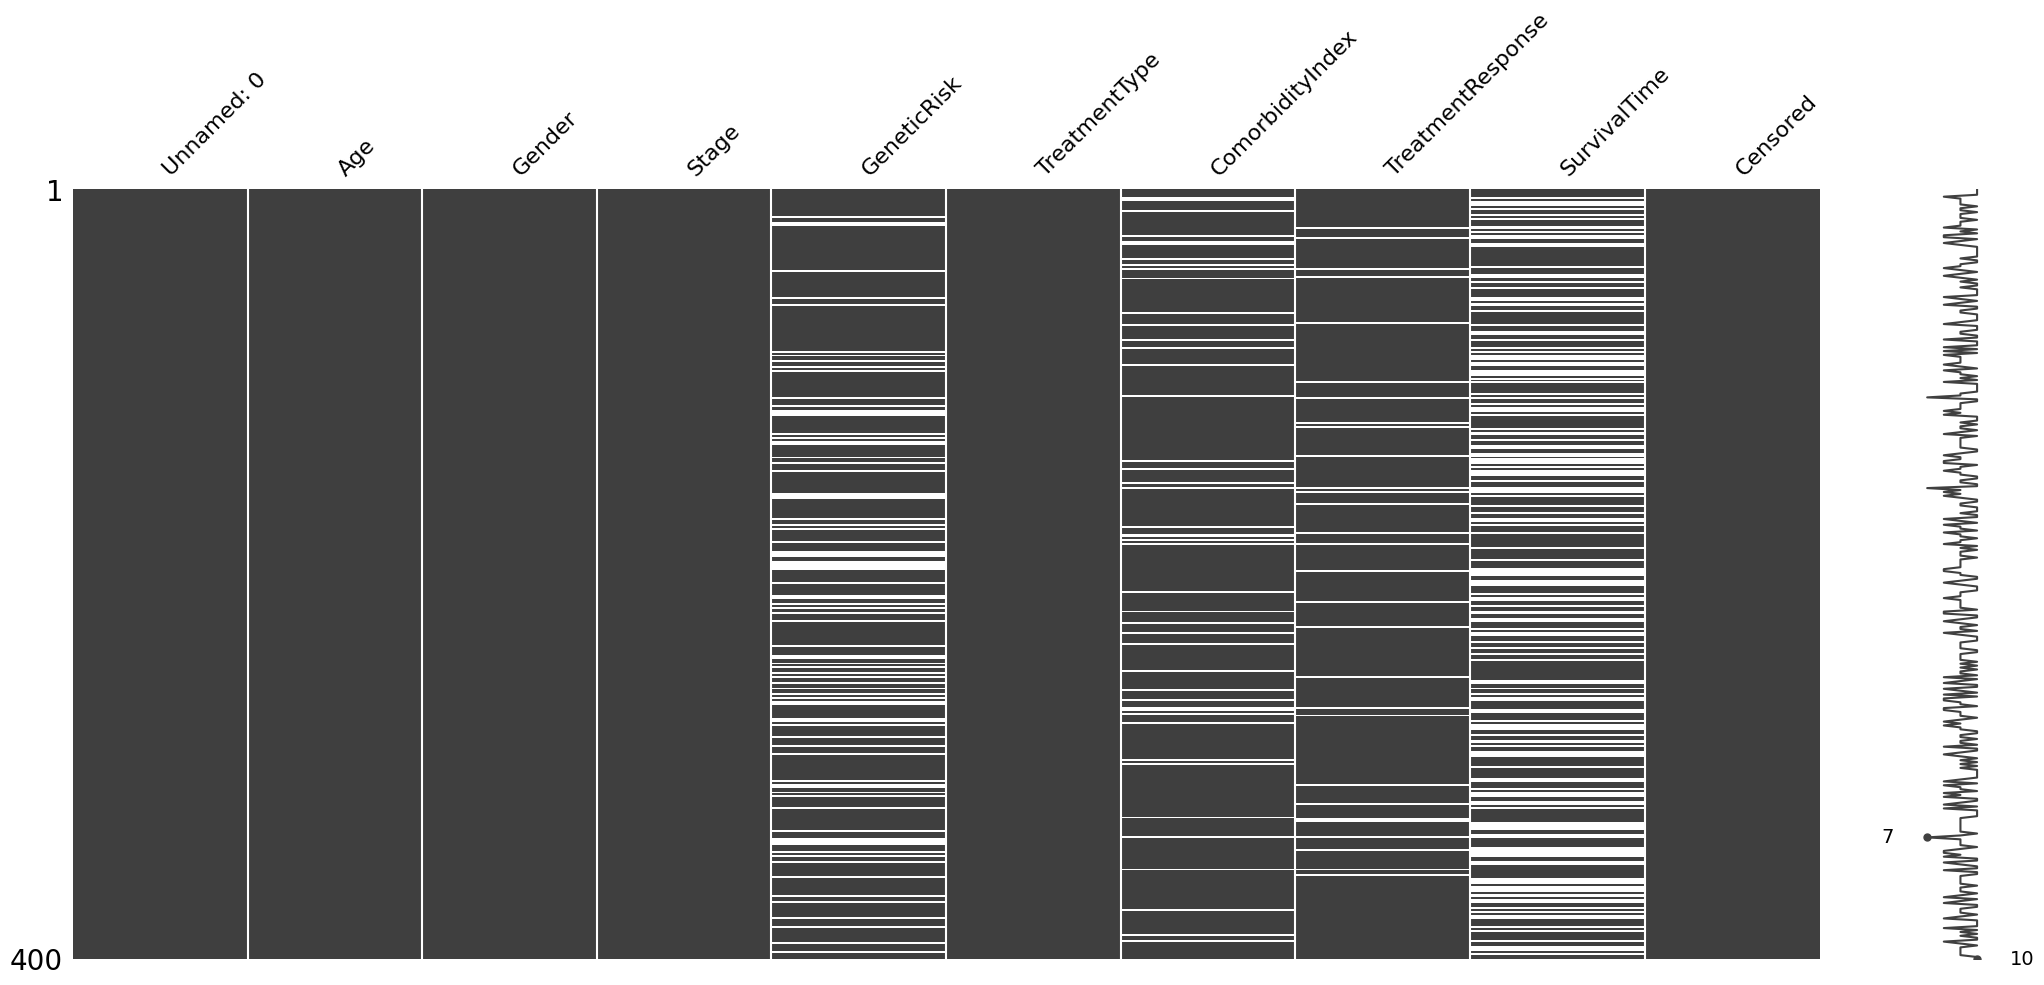

In [4]:
df = pd.read_csv('train_data.csv')
print(df.head())

plt.figure(figsize=(12, 8))
msno.matrix(df)
plt.show()

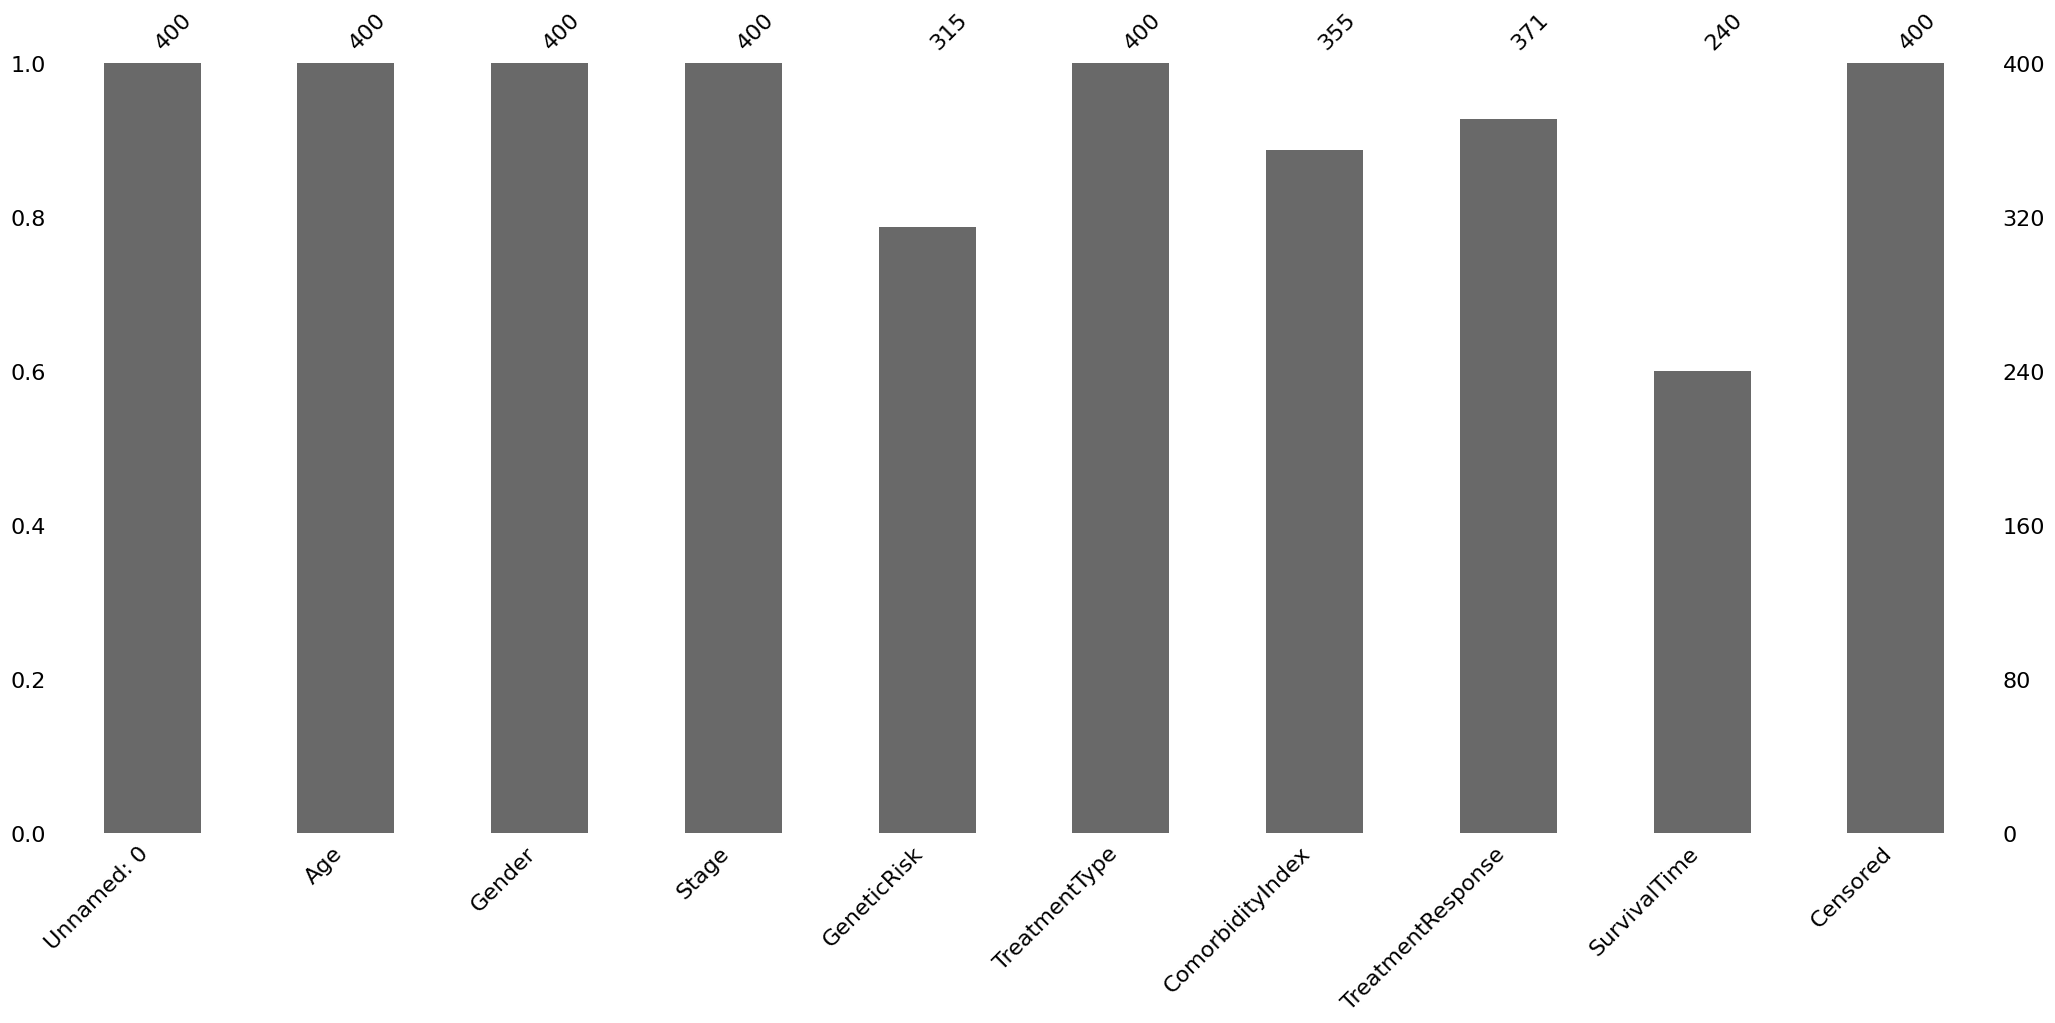

In [5]:
plt.figure(figsize=(12, 8))
msno.bar(df)
plt.show()

<Figure size 1200x800 with 0 Axes>

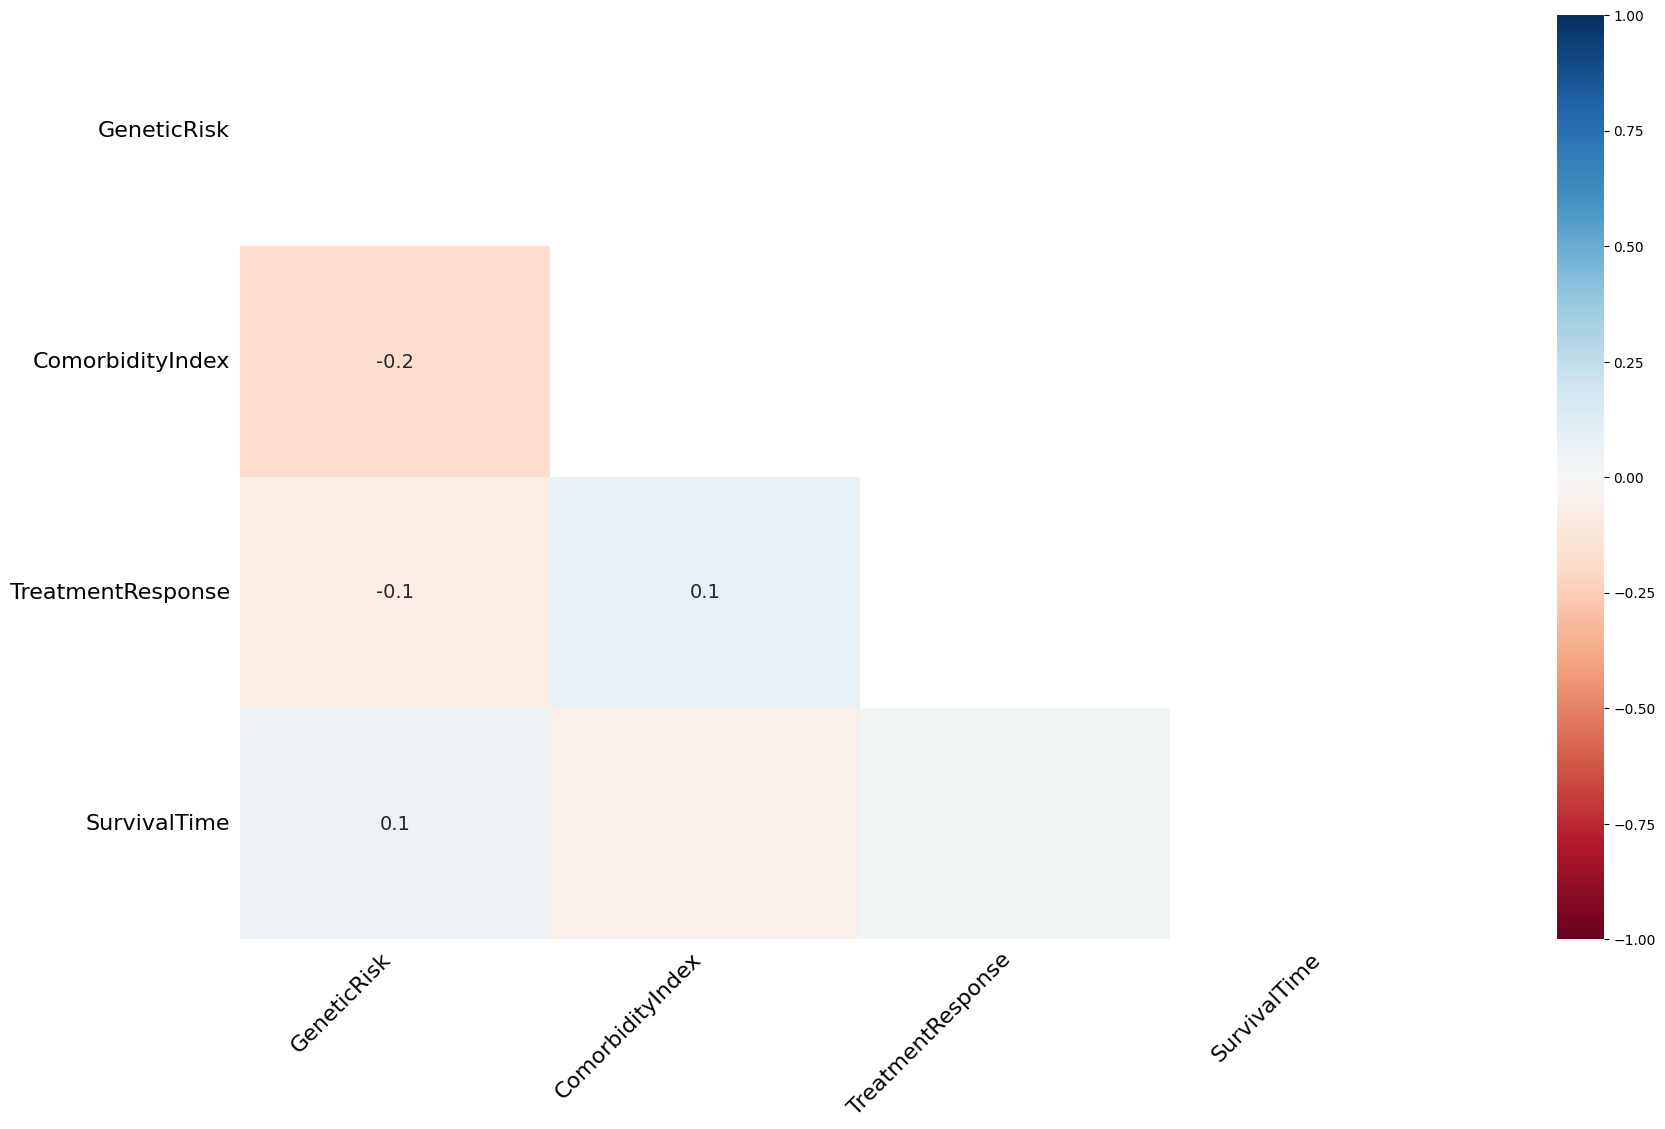

In [6]:
plt.figure(figsize=(12, 8))
msno.heatmap(df)
plt.show()

<Figure size 1200x800 with 0 Axes>

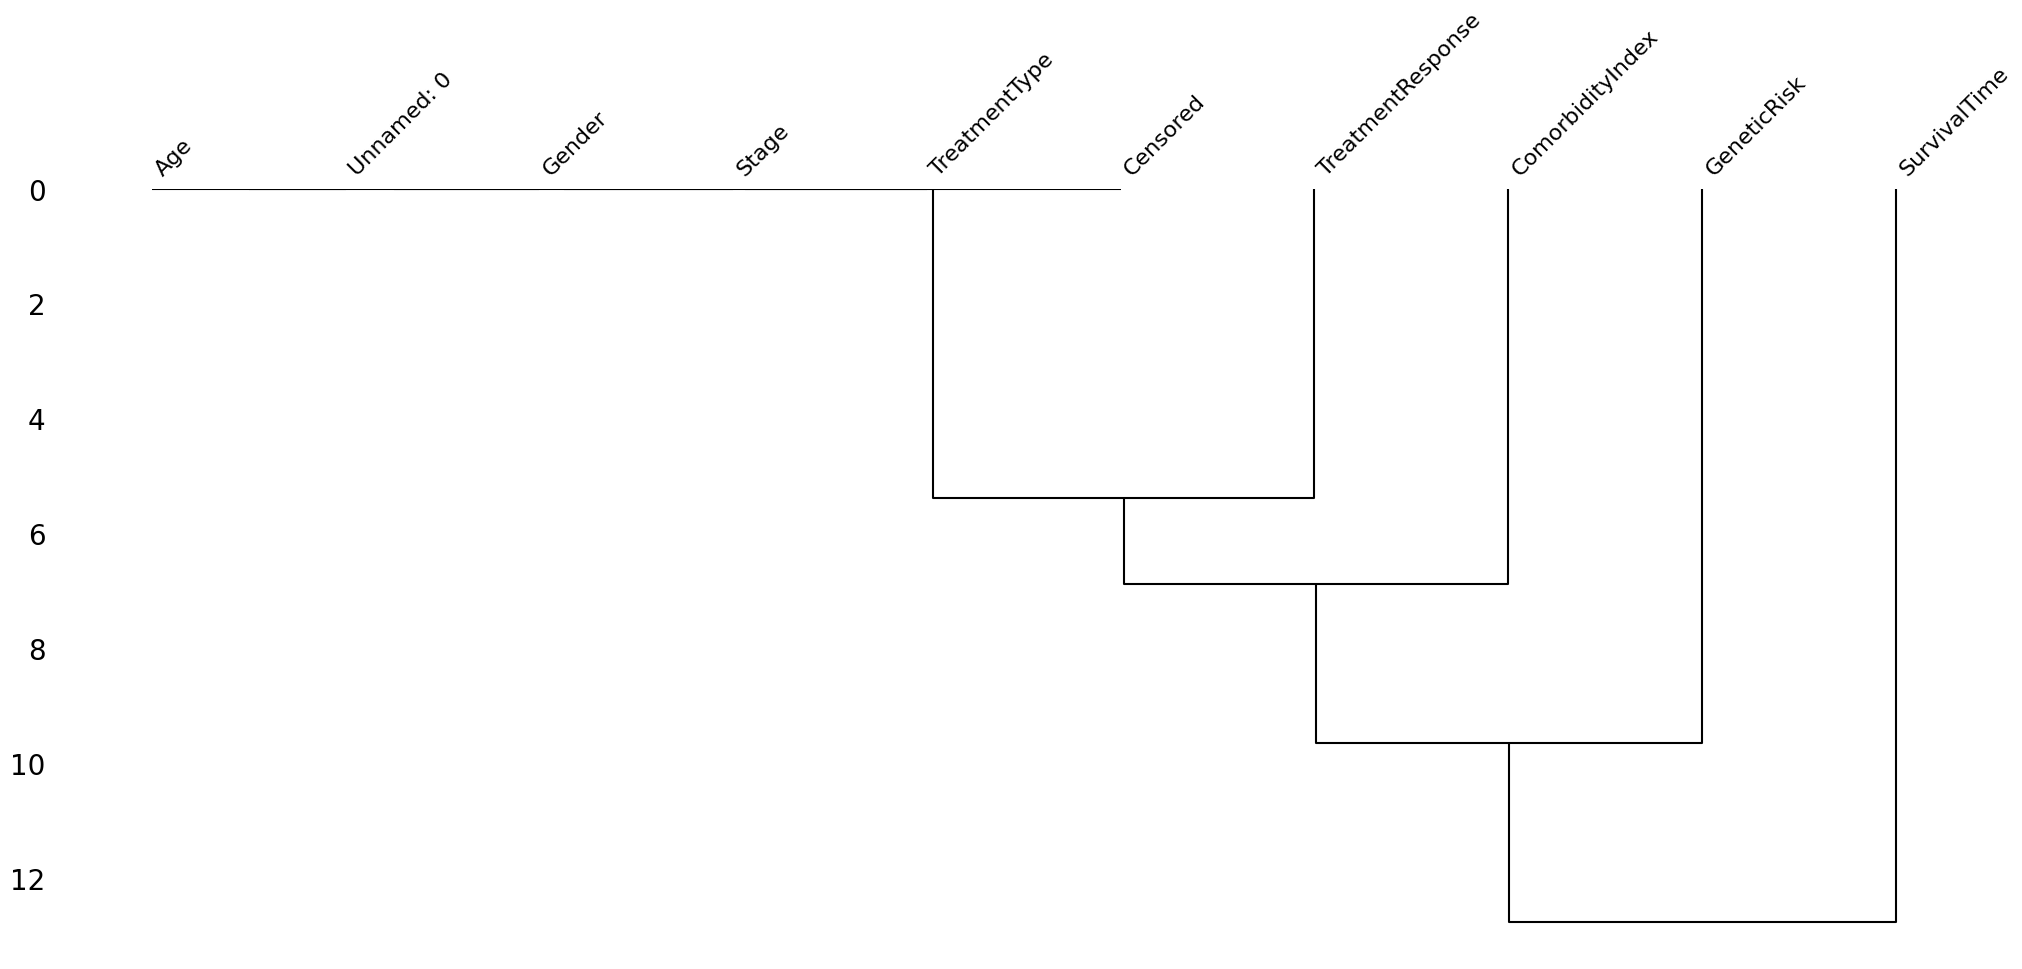

In [7]:
plt.figure(figsize=(12, 8))
msno.dendrogram(df)
plt.show()

In [8]:

# Filter rows with non-censored data and non-missing survival time
data_filtered = df[(df['SurvivalTime'].notna()) & (df['Censored'] == 0)]
data_filtered.dropna(axis=1, inplace = True)
# Count the remaining data points
remaining_points = data_filtered.shape[0]
remaining_points


/tmp/ipykernel_4013/4200345265.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.dropna(axis=1, inplace = True)


161

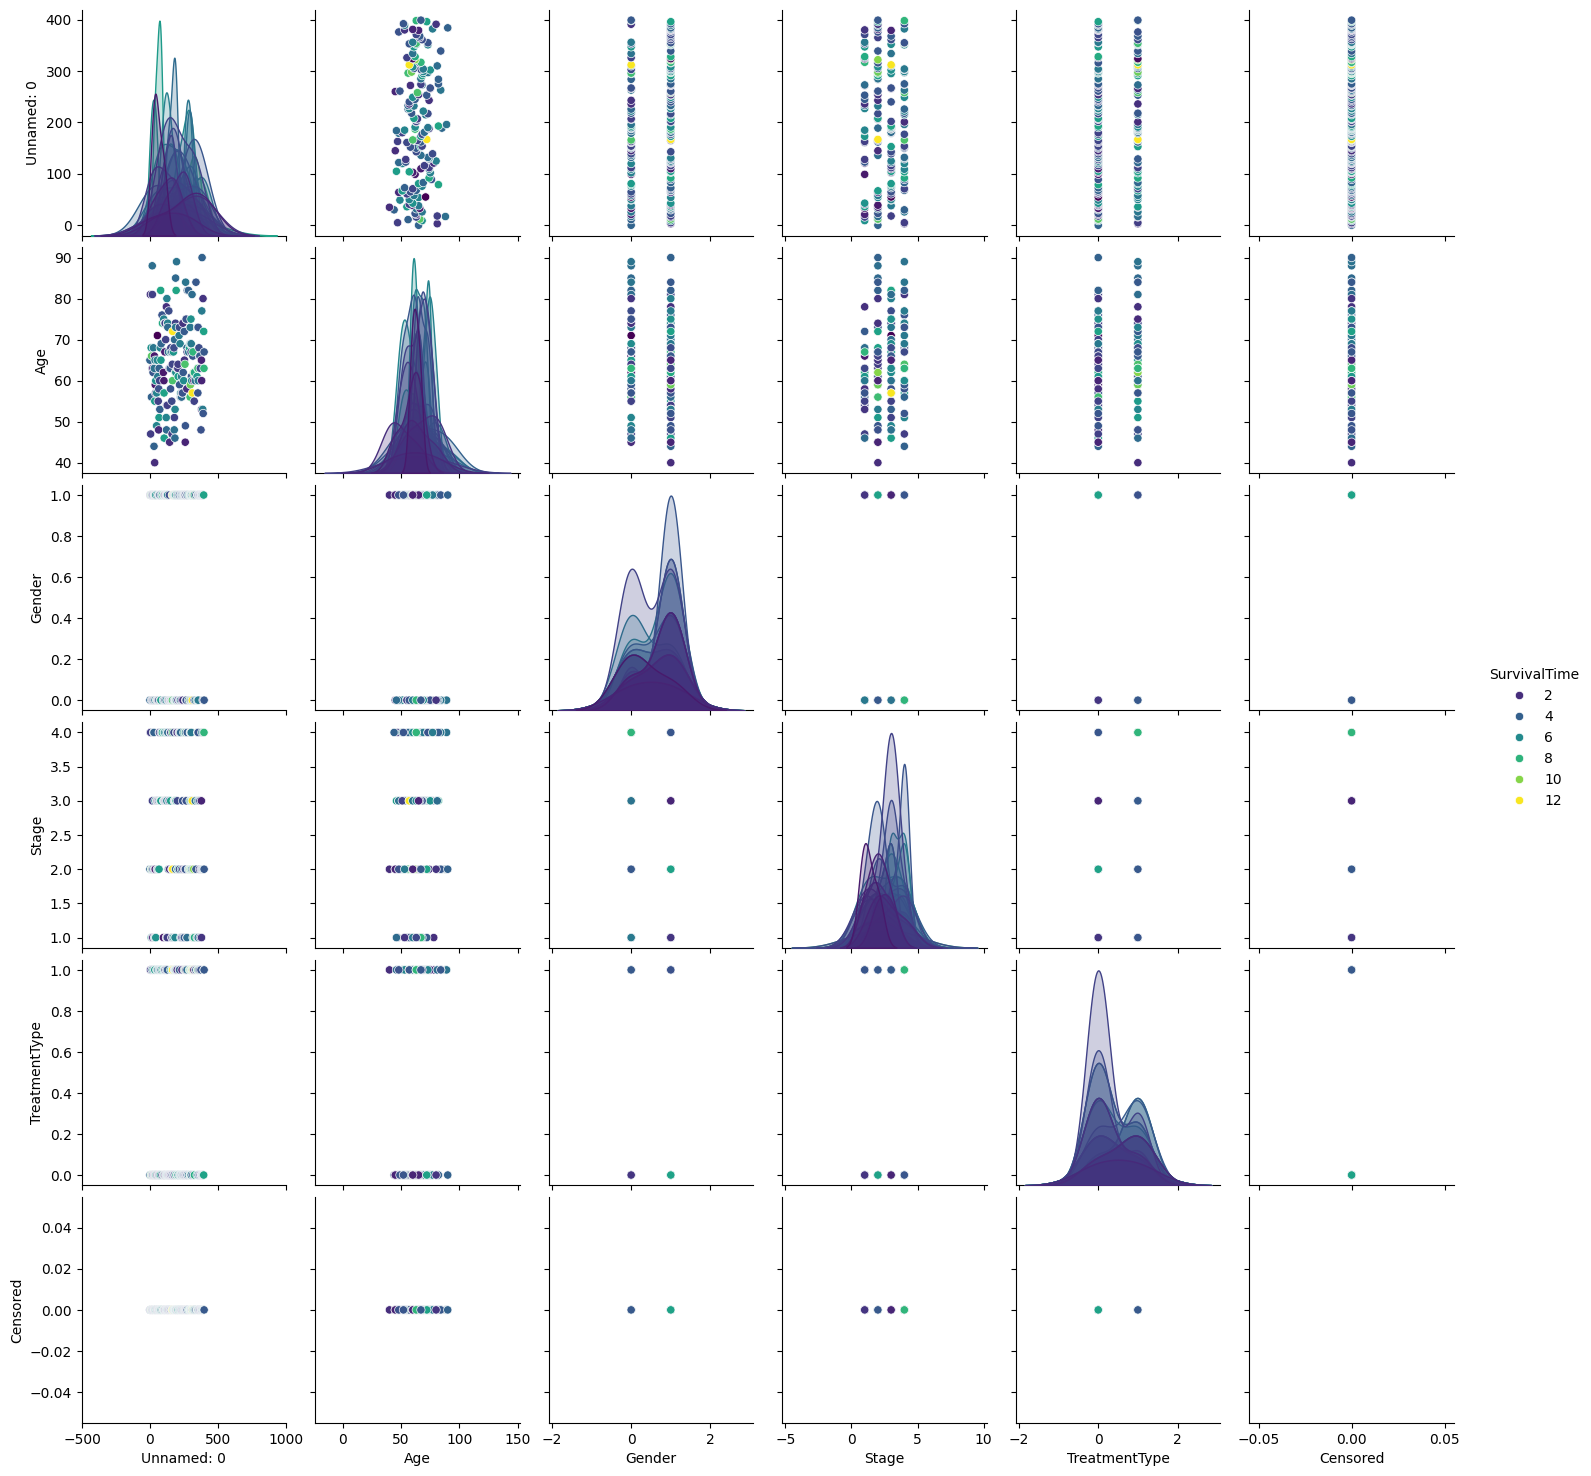

In [9]:


# Create the pairplot
sns.pairplot(data_filtered, diag_kind="kde", kind="scatter", hue="SurvivalTime", palette="viridis")

plt.show()


In [10]:
import pandas as pd


# Define the target vector (SurvivalTime)
y = df['SurvivalTime']

# Define the feature matrix 
X = df.drop(columns=['Unnamed: 0', 'SurvivalTime'])


In [11]:
def error_metric(y, y_hat, c):
    import numpy as np
    err = y-y_hat
    err = (1-c)*err**2 + c*np.maximum(0,err)**2
    return np.sum(err)/err.shape[0]

<>:58: SyntaxWarning: invalid escape sequence '\h'
<>:59: SyntaxWarning: invalid escape sequence '\h'
<>:58: SyntaxWarning: invalid escape sequence '\h'
<>:59: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_4013/3058996599.py:58: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('Predicted Survival Time ($\hat{y}$)')
/tmp/ipykernel_4013/3058996599.py:59: SyntaxWarning: invalid escape sequence '\h'
  plt.title('y vs. $\hat{y}$ Plot')


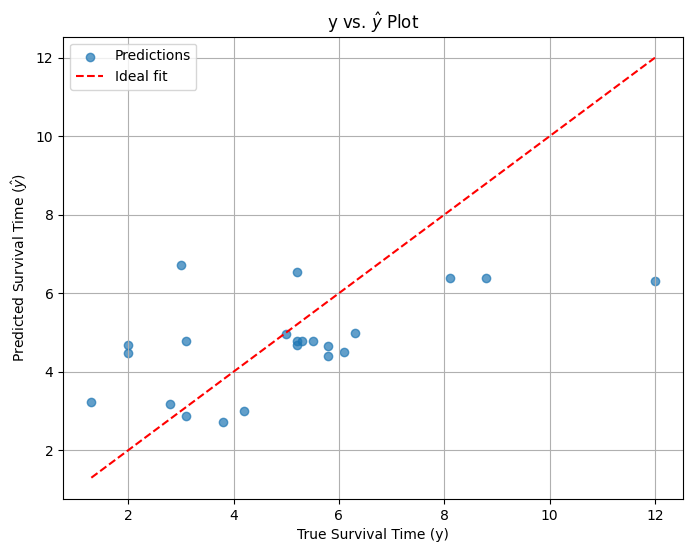

cv_scores: [3.20621122 5.8501971  5.07571091 3.92629962 3.4073382 ]
cmse_test: 3.9983211203636304


In [16]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
def train_baseline_model(csv_file):
    """
    Train a baseline Linear Regression model using cross-validation, 
    and plot the y vs. y_hat plot on a test set.

    Parameters:
    csv_file (str): Path to the CSV file containing the dataset.

    Returns:
    model (Pipeline): The trained pipeline (StandardScaler + LinearRegression).
    cv_scores (list): The cross-validation MSE scores for the model.
    cmse_test (float): The cMSE (MSE) on the test set.
    """
    # Load the data
    data = pd.read_csv(csv_file)
    
    # Filter uncensored data and drop rows with missing values
    data_uncensored = data[data['Censored'] == 0].dropna()
    
    # Define features (X) and target (y)
    X = data_uncensored[['Age', 'Gender', 'Stage', 'GeneticRisk', 'TreatmentType', 
                         'ComorbidityIndex', 'TreatmentResponse']]
    y = data_uncensored['SurvivalTime']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    
    # Perform cross-validation on the training set
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = -cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    
    # Train the model on the training set
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Compute cMSE on the test set
    cmse_test = mean_squared_error(y_test, y_pred)
    
    # Plot the y-y_hat plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, label="Predictions")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal fit')
    plt.xlabel('True Survival Time (y)')
    plt.ylabel('Predicted Survival Time ($\hat{y}$)')
    plt.title('y vs. $\hat{y}$ Plot')
    plt.legend()
    plt.grid()
    plt.show()
    
    print('cv_scores:',cv_scores)
    print('cmse_test:',cmse_test)
    # Return the trained model, CV scores, and test cMSE
    return pipeline, cv_scores, cmse_test

pipeline, cv_scores, _ = train_baseline_model('train_data.csv')


In [17]:
def generate_submission(csv_file, trained_model, output_file='baseline-submission-00.csv'):
    """
    Generate a submission file with model predictions.

    Parameters:
    csv_file (str): Path to the input CSV file with features.
    trained_model (Pipeline): The trained model pipeline.
    output_file (str): Name of the output CSV file to save predictions.

    Returns:
    None
    """
    # Load the input data
    data = pd.read_csv(csv_file)
    
    # Ensure necessary columns exist
    required_columns = ['Age', 'Gender', 'Stage', 'GeneticRisk', 
                        'TreatmentType', 'ComorbidityIndex', 'TreatmentResponse']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Input data must contain the following columns: {required_columns}")
    
    # Select features
    X = data[required_columns]
    
    # Handle missing values (if any)
    if X.isnull().any().any():
        print("Warning: Missing values detected. Filling with column means.")
        X = X.fillna(X.mean())
    
    # Predict using the trained model
    predictions = trained_model.predict(X)
    
    # Create a DataFrame for the submission
    submission = pd.DataFrame({
        'id': range(len(predictions)),
        '0': predictions
    })
    submission["id"] = submission.index
    # Save the submission to a CSV file
    submission.to_csv(output_file, index=False)
    print(f"Submission file saved as: {output_file}")
generate_submission(csv_file='test_data.csv', trained_model = pipeline)

Submission file saved as: baseline-submission-00.csv


In [18]:
import numpy as np

# Gradient descent function
def gradient_descent(X, y, c, learning_rate=0.01, lambda_ridge=0.1, num_iterations=1000):
    """
    Perform gradient descent with cMSE loss and Ridge regularization.
    
    Parameters:
        X (numpy array): Feature matrix (N x d).
        y (numpy array): True target values (N x 1).
        c (numpy array): Censoring indicator (N x 1).
        learning_rate (float): Learning rate for gradient descent.
        lambda_ridge (float): Regularization parameter for Ridge.
        num_iterations (int): Number of iterations.
        
    Returns:
        theta (numpy array): Optimized model parameters.
        losses (list): Loss at each iteration.
    """
    N, d = X.shape
    theta = np.random.randn(d)  # Initialize weights randomly
    losses = []
    
    for iteration in range(num_iterations):
        # Compute predictions
        y_hat = X.dot(theta)
        
        # Compute gradient of cMSE loss
        err = y - y_hat
        grad_cMSE = -2 * (1 - c) * err / N - 2 * c * np.maximum(0, err) / N
        
        # Add Ridge regularization gradient
        grad_ridge = 2 * lambda_ridge * theta
        
        # Total gradient
        gradient = X.T.dot(grad_cMSE) + grad_ridge
        
        # Update weights
        theta -= learning_rate * gradient
        
        # Compute loss (cMSE + Ridge)
        loss_cMSE = np.mean((1 - c) * err**2 + c * np.maximum(0, err)**2)
        loss_ridge = lambda_ridge * np.sum(theta**2)
        losses.append(loss_cMSE + loss_ridge)
    
    return theta, losses


In [19]:
import numpy as np

# Gradient descent function
def gradient_descent(X, y, c, learning_rate=0.01, lambda_ridge=0.1, num_iterations=1000):
    """
    Perform gradient descent with cMSE loss and Ridge regularization.
    
    Parameters:
        X (numpy array): Feature matrix (N x d).
        y (numpy array): True target values (N x 1).
        c (numpy array): Censoring indicator (N x 1).
        learning_rate (float): Learning rate for gradient descent.
        lambda_ridge (float): Regularization parameter for Ridge.
        num_iterations (int): Number of iterations.
        
    Returns:
        theta (numpy array): Optimized model parameters.
        losses (list): Loss at each iteration.
    """
    N, d = X.shape
    theta = np.random.randn(d)  # Initialize weights randomly
    losses = []
    
    for iteration in range(num_iterations):
        # Compute predictions
        y_hat = X.dot(theta)
        
        # Compute gradient of cMSE loss
        err = y - y_hat
        grad_cMSE = -2 * (1 - c) * err / N - 2 * c * np.maximum(0, err) / N
        
        # Add Ridge regularization gradient
        grad_ridge = 2 * lambda_ridge * theta
        
        # Total gradient
        gradient = X.T.dot(grad_cMSE) + grad_ridge
        
        # Update weights
        theta -= learning_rate * gradient
        
        # Compute loss (cMSE + Ridge)
        loss_cMSE = np.mean((1 - c) * err**2 + c * np.maximum(0, err)**2)
        loss_ridge = lambda_ridge * np.sum(theta**2)
        losses.append(loss_cMSE + loss_ridge)
    
    return theta, losses


<>:69: SyntaxWarning: invalid escape sequence '\h'
<>:70: SyntaxWarning: invalid escape sequence '\h'
<>:69: SyntaxWarning: invalid escape sequence '\h'
<>:70: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_4013/2288392507.py:69: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('Predicted Survival Time ($\hat{y}$)')
/tmp/ipykernel_4013/2288392507.py:70: SyntaxWarning: invalid escape sequence '\h'
  plt.title('y vs. $\hat{y}$ Plot (Tuned Polynomial Regression with CV)')


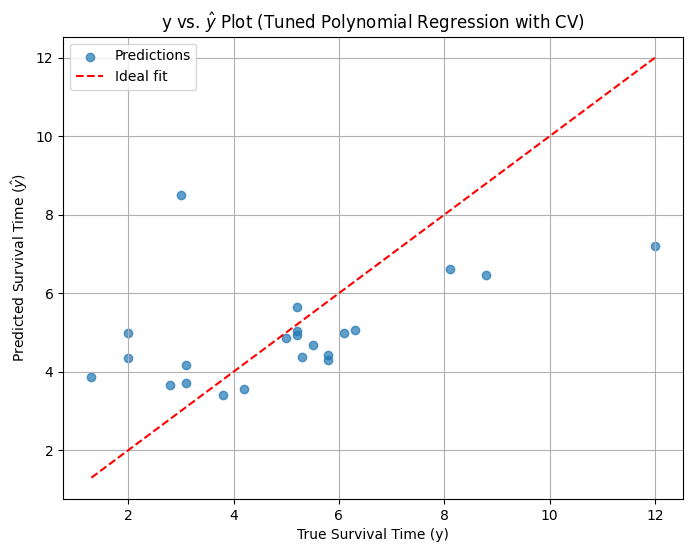

In [23]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

def train_polynomial_model(csv_file, cv_folds=5):
    """
    Train a Polynomial Regression model with hyperparameter tuning and cross-validation.

    Parameters:
    csv_file (str): Path to the CSV file containing the dataset.
    cv_folds (int): Number of folds for cross-validation during grid search.

    Returns:
    best_model (Pipeline): The best pipeline (PolynomialFeatures + StandardScaler + Ridge).
    best_params (dict): The best hyperparameters found by GridSearchCV.
    mean_cv_score (float): The mean cross-validated score (negative MSE) for the best model.
    cmse_test (float): The cMSE (MSE) on the test set.
    """
    # Load the data
    data = pd.read_csv(csv_file)
    
    # Filter uncensored data and drop rows with missing values
    data_uncensored = data[data['Censored'] == 0].dropna()
    
    # Define features (X) and target (y)
    X = data_uncensored[['Age', 'Gender', 'Stage', 'GeneticRisk', 'TreatmentType', 
                         'ComorbidityIndex', 'TreatmentResponse']]
    y = data_uncensored['SurvivalTime']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a pipeline with PolynomialFeatures and Ridge regression
    pipeline = Pipeline([
        ('poly_features', PolynomialFeatures(include_bias=False)),
        ('scaler', StandardScaler()),
        ('regressor', Ridge())
    ])
    
    # Define the grid of hyperparameters to search
    param_grid = {
        'poly_features__degree': [1, 2, 3, 4, 5, 6],  # Degrees of polynomial features
        'regressor__alpha': [0.1, 1, 10, 100, 700]  # Regularization strength for Ridge
    }
    
    # Perform GridSearchCV with cross-validation
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=cv_folds, scoring='neg_mean_squared_error', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    mean_cv_score = -grid_search.best_score_  # Convert from negative MSE to MSE
    
    # Predict on the test set using the best model
    y_pred = best_model.predict(X_test)
    
    # Compute cMSE on the test set
    cmse_test = mean_squared_error(y_test, y_pred)
    
    # Plot the y-y_hat plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, label="Predictions")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal fit')
    plt.xlabel('True Survival Time (y)')
    plt.ylabel('Predicted Survival Time ($\hat{y}$)')
    plt.title('y vs. $\hat{y}$ Plot (Tuned Polynomial Regression with CV)')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Return the best model, best parameters, and scores
    return best_model, best_params, mean_cv_score, cmse_test
poly_model, params,mean_cv_score, cmse_test = train_polynomial_model(csv_file='train_data.csv')

In [24]:
generate_submission(csv_file = 'test_data.csv', trained_model=poly_model , output_file='Nonlinear-submission-00.csv')

Submission file saved as: Nonlinear-submission-00.csv


<>:71: SyntaxWarning: invalid escape sequence '\h'
<>:72: SyntaxWarning: invalid escape sequence '\h'
<>:71: SyntaxWarning: invalid escape sequence '\h'
<>:72: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_4013/1601355204.py:71: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('Predicted Survival Time ($\hat{y}$)')
/tmp/ipykernel_4013/1601355204.py:72: SyntaxWarning: invalid escape sequence '\h'
  plt.title('y vs. $\hat{y}$ Plot (Best Model)')


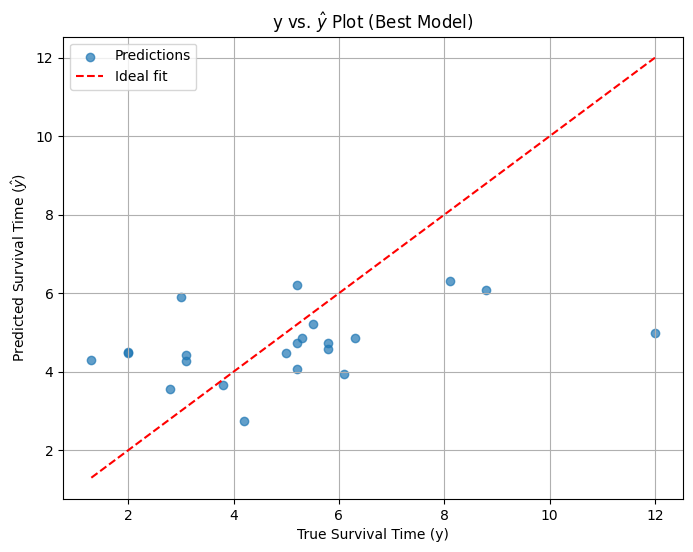

Best Parameters: {'regressor__n_neighbors': 10, 'regressor__p': 1, 'regressor__weights': 'uniform'}
Test set cMSE: 4.9046045454545455


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

def train_knn(csv_file, param_grid=None):
    """
    Train a k-NN regressor model with hyperparameter tuning using GridSearchCV,
    and perform cross-validation on the best model.

    Parameters:
    csv_file (str): Path to the CSV file containing the dataset.
    param_grid (dict): Dictionary of hyperparameters to tune. 
                       Default is for k-NN.

    Returns:
    best_model (Pipeline): The trained pipeline with the best hyperparameters.
    best_params (dict): The best hyperparameters from GridSearchCV.
    cv_scores (list): Cross-validation scores of the best model on training data.
    cmse_test (float): The cMSE (MSE) on the test set.
    """
    # Default parameter grid for k-NN
    if param_grid is None:
        param_grid = {
            'regressor__n_neighbors': [3, 5, 10, 20],
            'regressor__weights': ['uniform', 'distance'],
            'regressor__p': [1, 2]  # Manhattan and Euclidean distances
        }
    
    # Load the data
    data = pd.read_csv(csv_file)
    
    # Filter uncensored data and drop rows with missing values
    data_uncensored = data[data['Censored'] == 0].dropna()
    
    # Define features (X) and target (y)
    X = data_uncensored[['Age', 'Gender', 'Stage', 'GeneticRisk', 'TreatmentType', 
                         'ComorbidityIndex', 'TreatmentResponse']]
    y = data_uncensored['SurvivalTime']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor())
    ])
    
    # Apply GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Perform cross-validation on the best model
    cv_scores = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    # Predict on the test set
    y_pred = best_model.predict(X_test)
    
    # Compute cMSE on the test set
    cmse_test = mean_squared_error(y_test, y_pred)
    
    # Plot the y-y_hat plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, label="Predictions")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal fit')
    plt.xlabel('True Survival Time (y)')
    plt.ylabel('Predicted Survival Time ($\hat{y}$)')
    plt.title('y vs. $\hat{y}$ Plot (Best Model)')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Return the best model, best parameters, CV scores, and test cMSE
    return best_model, best_params, cv_scores, cmse_test

# Train and tune the model
knn_model, best_params, cv_scores, cmse_test = train_knn('train_data.csv')
print("Best Parameters:", best_params)
print("Test set cMSE:", cmse_test)

In [27]:
generate_submission(csv_file = 'test_data.csv', trained_model=knn_model , output_file='Nonlinear-submission(knn)-00.csv')

Submission file saved as: Nonlinear-submission(knn)-00.csv


<>:70: SyntaxWarning: invalid escape sequence '\h'
<>:71: SyntaxWarning: invalid escape sequence '\h'
<>:70: SyntaxWarning: invalid escape sequence '\h'
<>:71: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_4013/317725730.py:70: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('Predicted Survival Time ($\hat{y}$)')
/tmp/ipykernel_4013/317725730.py:71: SyntaxWarning: invalid escape sequence '\h'
  plt.title('y vs. $\hat{y}$ Plot (Tuned Model)')


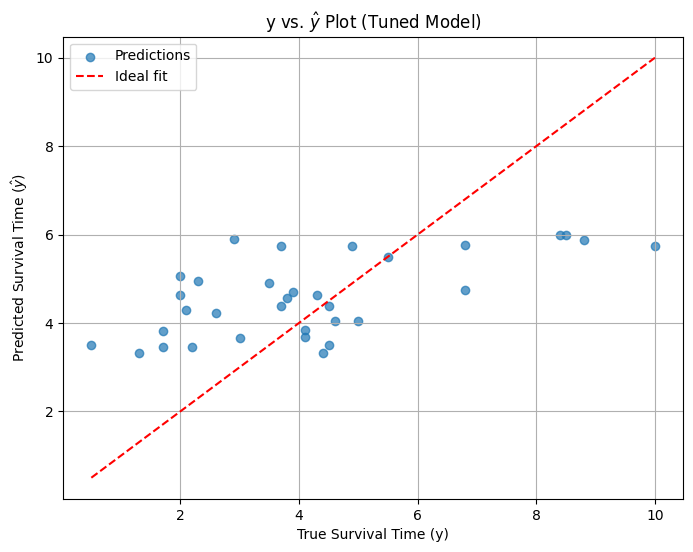

Best Hyperparameters: {'min_samples_leaf': 10, 'max_iter': 100, 'max_depth': 5, 'learning_rate': 0.01, 'l2_regularization': 0.0}
Test set cMSE: 3.604401984360338


In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

def train_hist_gradient_boosting(csv_file):
    """
    Train a HistGradientBoostingRegressor model with hyperparameter tuning.

    Parameters:
    csv_file (str): Path to the CSV file containing the dataset.

    Returns:
    best_model (HistGradientBoostingRegressor): The best model after hyperparameter tuning.
    best_params (dict): The best hyperparameters found.
    cv_scores (float): The cross-validated score of the best model.
    cmse_test (float): The cMSE (MSE) on the test set.
    """
    # Load the data
    data = pd.read_csv(csv_file)
    
    # Filter uncensored data and drop rows where target is missing
    data_uncensored = data[data['Censored'] == 0].dropna(subset=['SurvivalTime'])
    
    # Define features (X) and target (y)
    X = data_uncensored[['Age', 'Gender', 'Stage', 'GeneticRisk', 'TreatmentType', 
                         'ComorbidityIndex', 'TreatmentResponse']]
    y = data_uncensored['SurvivalTime']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define the base model
    model = HistGradientBoostingRegressor(random_state=42)
    
    # Define the hyperparameter grid
    param_distributions = {
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7, None],
        'min_samples_leaf': [10, 20, 30],
        'max_iter': [100, 200, 300],
        'l2_regularization': [0.0, 0.1, 1.0],
    }
    
    # Randomized search with 5-fold cross-validation
    random_search = RandomizedSearchCV(
        model, 
        param_distributions, 
        n_iter=50,  # Number of random combinations to try
        scoring='neg_mean_squared_error',
        cv=5,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    
    # Perform the search
    random_search.fit(X_train, y_train)
    
    # Get the best model and parameters
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # Evaluate the best model on the test set
    y_pred = best_model.predict(X_test)
    cmse_test = mean_squared_error(y_test, y_pred)
    
    # Plot the y-y_hat plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, label="Predictions")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal fit')
    plt.xlabel('True Survival Time (y)')
    plt.ylabel('Predicted Survival Time ($\hat{y}$)')
    plt.title('y vs. $\hat{y}$ Plot (Tuned Model)')
    plt.legend()
    plt.grid()
    plt.show()

    # Return the best model, its parameters, and test cMSE
    return best_model, best_params, cmse_test    
    
hist_gradient, hist_best_params, hist_cmse = train_hist_gradient_boosting(csv_file='train_data.csv')
print("Best Hyperparameters:", hist_best_params)
print("Test set cMSE:", hist_cmse)

In [30]:
def generate_submission_hist(csv_file, trained_model, output_file='handle-missing-submission-00.csv'):
    """
    Generate a submission file with model predictions using HistGradientBoostingRegressor.

    Parameters:
    csv_file (str): Path to the input CSV file with features.
    trained_model (HistGradientBoostingRegressor): The trained model.
    output_file (str): Name of the output CSV file to save predictions.

    Returns:
    None
    """
    # Load the input data
    data = pd.read_csv(csv_file)
    
    # Ensure necessary columns exist
    required_columns = ['Age', 'Gender', 'Stage', 'GeneticRisk', 
                        'TreatmentType', 'ComorbidityIndex', 'TreatmentResponse']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Input data must contain the following columns: {required_columns}")
    
    # Select features
    X = data[required_columns]
    
    # Predict using the trained model
    predictions = trained_model.predict(X)
    
    # Create a DataFrame for the submission
    submission = pd.DataFrame({
        'id': data['id'],  # Ensure 'id' column exists in the input
        'SurvivalTime': predictions
    })
    
    # Save the submission to a CSV file
    submission.to_csv(output_file, index=False)
    print(f"Submission file saved as: {output_file}")
# Generate the submission file
generate_submission_hist(csv_file = 'test_data.csv', trained_model = hist_gradient)

Submission file saved as: handle-missing-submission-00.csv


Missing SurvivalTime: 160 rows.


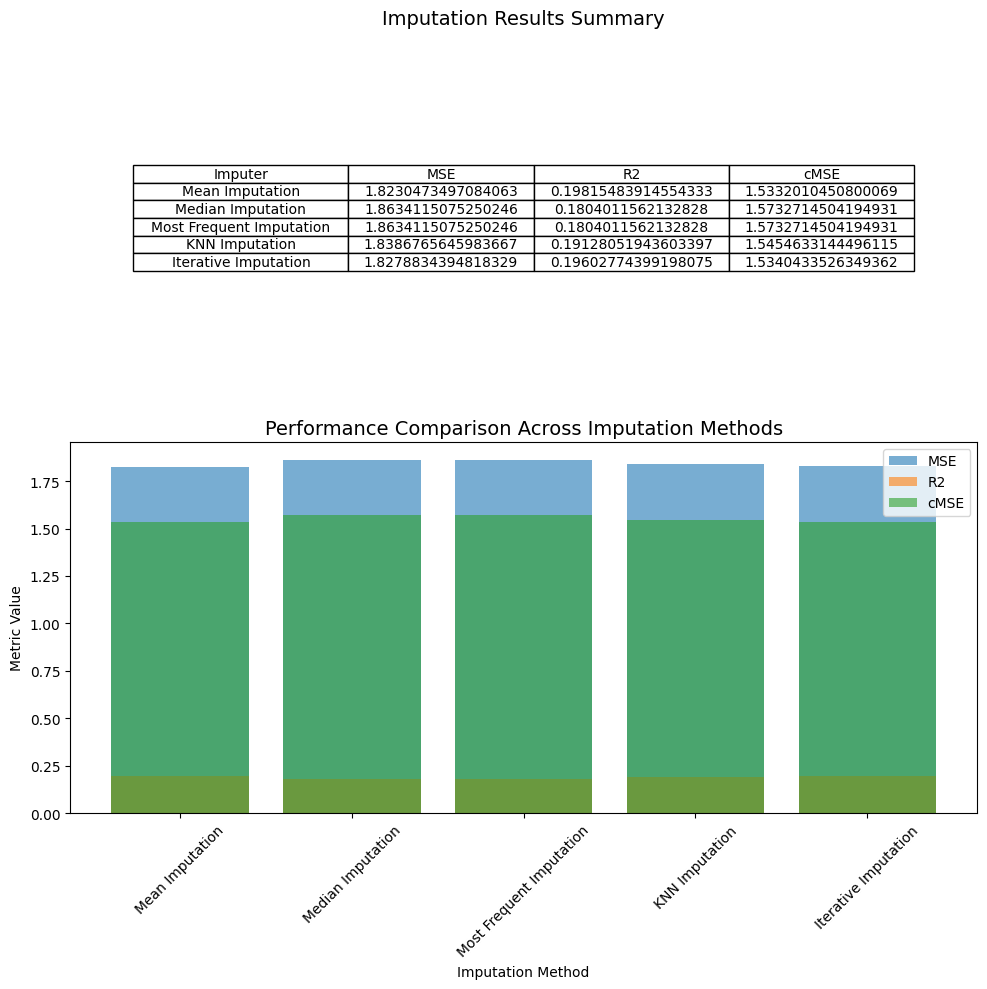

In [17]:
from sklearn.experimental import enable_iterative_imputer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
import matplotlib.pyplot as plt

# Generate synthetic dataset with missing values
df = pd.read_csv('train_data.csv')

# Custom error metric
def error_metric(y, y_hat, c):
    err = y - y_hat
    err = (1 - c) * err**2 + c * np.maximum(0, err)**2
    return np.sum(err) / err.shape[0]

# Handle missing SurvivalTime
if df["SurvivalTime"].isnull().sum() > 0:
    print(f"Missing SurvivalTime: {df['SurvivalTime'].isnull().sum()} rows.")
    
    # Impute SurvivalTime (using IterativeImputer)
    survival_imputer = IterativeImputer(random_state=42)
    df["SurvivalTime"] = survival_imputer.fit_transform(df[["SurvivalTime"]])

# Split into features and target
X = df.drop(columns=["SurvivalTime", "Censored"])
y = df["SurvivalTime"]
c = df["Censored"]

# Define a function to train and evaluate a model with the custom metric
def train_and_evaluate(X, y, c, imputer, imputer_name):
    # Impute missing data
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Train-test split
    X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
        X_imputed, y, c, test_size=0.3, random_state=42
    )
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    custom_err = error_metric(y_test.to_numpy(), y_pred, c_test.to_numpy())
    
    return [imputer_name, mse, r2, custom_err]

# Different imputation strategies
imputers = {
    "Mean Imputation": SimpleImputer(strategy="mean"),
    "Median Imputation": SimpleImputer(strategy="median"),
    "Most Frequent Imputation": SimpleImputer(strategy="most_frequent"),
    "KNN Imputation": KNNImputer(n_neighbors=3),
    "Iterative Imputation": IterativeImputer(random_state=42),
}

# Evaluate models with different imputers and store results
results = []
for name, imputer in imputers.items():
    results.append(train_and_evaluate(X, y, c, imputer, name))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=["Imputer", "MSE", "R2", "cMSE"])

# Plot results
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Table Visualization
axs[0].axis("off")  # Hide the axis for the table
table = axs[0].table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    cellLoc="center",
    loc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_df.columns))))
axs[0].set_title("Imputation Results Summary", fontsize=14)

# Bar Plot Visualization
metrics = ["MSE", "R2", "cMSE"]
for metric in metrics:
    axs[1].bar(results_df["Imputer"], results_df[metric], label=metric, alpha=0.6)

axs[1].set_title("Performance Comparison Across Imputation Methods", fontsize=14)
axs[1].set_ylabel("Metric Value")
axs[1].set_xlabel("Imputation Method")
axs[1].legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

def train_nn_model(csv_file):
    """
    Train a simple Neural Network model using cross-validation and return the model.

    Parameters:
    csv_file (str): Path to the CSV file containing the dataset.

    Returns:
    model (Pipeline): The trained pipeline (StandardScaler + MLPRegressor).
    cv_scores (list): The cross-validation MSE scores for the model.
    cmse_test (float): The cMSE (MSE) on the test set.
    """
    # Load the data
    data = pd.read_csv(csv_file)
    
    # Filter uncensored data and drop rows with missing values
    data_uncensored = data[data['Censored'] == 0].dropna()
    
    # Define features (X) and target (y)
    X = data_uncensored[['Age', 'Gender', 'Stage', 'GeneticRisk', 'TreatmentType', 
                         'ComorbidityIndex', 'TreatmentResponse']]
    y = data_uncensored['SurvivalTime']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a pipeline with StandardScaler and MLPRegressor
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42))
    ])
    
    # Perform cross-validation on the training set
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = -cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    
    # Train the model on the training set
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Compute cMSE on the test set
    cmse_test = mean_squared_error(y_test, y_pred)
    
    # Return the trained model, CV scores, and test cMSE
    return pipeline, cv_scores, cmse_test


In [32]:
def generate_submission_nn(csv_file, trained_model, output_file='semisupervised-submission-00.csv'):
    """
    Generate a submission file with model predictions using a simple neural network.

    Parameters:
    csv_file (str): Path to the input CSV file with features.
    trained_model (Pipeline): The trained neural network pipeline.
    output_file (str): Name of the output CSV file to save predictions.

    Returns:
    None
    """
    # Load the input data
    data = pd.read_csv(csv_file)
    
    # Ensure necessary columns exist
    required_columns = ['Age', 'Gender', 'Stage', 'GeneticRisk', 
                        'TreatmentType', 'ComorbidityIndex', 'TreatmentResponse']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Input data must contain the following columns: {required_columns}")
    
    # Select features
    X = data[required_columns]
    
    # Handle missing values (if any)
    if X.isnull().any().any():
        print("Warning: Missing values detected. Filling with column means.")
        X = X.fillna(X.mean())
    
    # Predict using the trained model
    predictions = trained_model.predict(X)
    
    # Create a DataFrame for the submission
    submission = pd.DataFrame({
        'id': data['id'],  # Ensure 'id' column exists in the input
        'SurvivalTime': predictions
    })
    
    # Save the submission to a CSV file
    submission.to_csv(output_file, index=False)
    print(f"Submission file saved as: {output_file}")


In [19]:
# Train the model using your training data
trained_nn_model, nn_cv_scores, nn_cmse_test = train_nn_model('train_data.csv')
print("Cross-validation MSE scores:", nn_cv_scores)
print("Mean CV MSE:", np.mean(nn_cv_scores))
print("Test set cMSE:", nn_cmse_test)

# Generate the submission file using the trained model
generate_submission_nn('test_data.csv', trained_nn_model)


NameError: name 'KFold' is not defined

Test MSE: 1.9857
Test Custom Error Metric: 1.6923


/home/sisard/anaconda3/envs/ml_erasmus/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


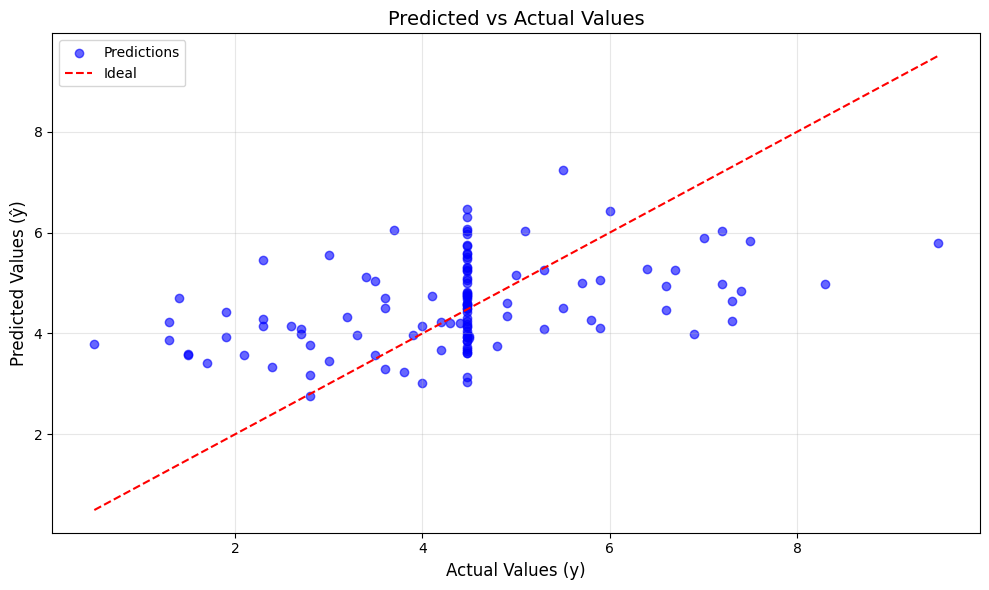

In [22]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Impute missing values using Mean Imputation
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
    X_scaled, y, c, test_size=0.3, random_state=42
)

# Define and train the MLP Regressor
mlp = MLPRegressor(
    hidden_layer_sizes=(64,),  # One hidden layer with 64 neurons
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42
)
mlp.fit(X_train, y_train)

# Evaluate the model
y_pred = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

# Calculate custom error metric
custom_err = error_metric(y_test.to_numpy(), y_pred, c_test.to_numpy())
print(f"Test Custom Error Metric: {custom_err:.4f}")

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color="blue", alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="Ideal")
plt.xlabel("Actual Values (y)", fontsize=12)
plt.ylabel("Predicted Values (ŷ)", fontsize=12)
plt.title("Predicted vs Actual Values", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [21]:
!pip install torch


  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.21.5-py3-none-manylinux2014_